# Model to Predict the Burned Area of Forest Fires

## 1. Problem Definition

Abstract: This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data.

## 2. Data

The dataset was taken from the UCI Datasets Website:
https://archive.ics.uci.edu/ml/datasets/forest+fires


## 3. Features

**Data Dictionary:**

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).



## Setting up tools and data

In [2]:
# import necessary tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# load data
fire_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/forestfires.csv")
fire_data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [ ]:
# checking datatypes and missing values
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    int8   
 3   day     517 non-null    int8   
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), int8(2)
memory usage: 45.6 KB


### Convert Object datatype into categories and then to numbers

The month and day column is object type. Process it to be included for the regression analysis.

In [ ]:
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    int8   
 3   day     517 non-null    int8   
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), int8(2)
memory usage: 45.6 KB


In [ ]:
# This will turn all of the string value into category values
for label, content in fire_data.items():
    if pd.api.types.is_string_dtype(content):
        fire_data[label] = content.astype("category").cat.as_ordered()
        fire_data[label] = pd.Categorical(content).codes+1

# turn categorical value into numerical form
fire_data["month"] = pd.Categorical(fire_data["month"]).codes+1
fire_data["day"] = pd.Categorical(fire_data["day"]).codes+1

fire_data

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,8,1,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,11,6,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,11,3,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,8,1,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,8,4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,2,4,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,2,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,2,3,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


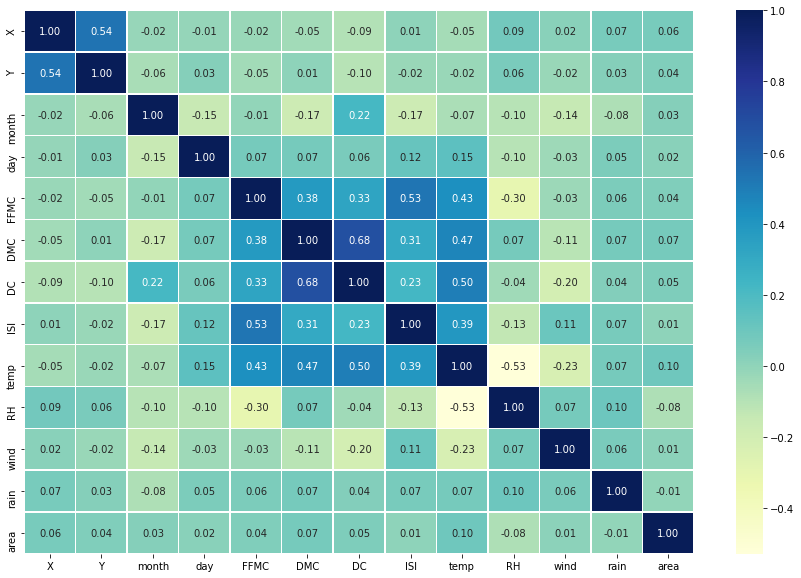

In [ ]:
# view correlation between each variable

corr_matrix = fire_data.corr()

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");


In [ ]:
# split into X and y
X = fire_data.drop(["area"], axis=1)
y = fire_data["area"]

In [ ]:
X.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,8,1,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,11,6,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,11,3,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,8,1,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,8,4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


In [ ]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area, dtype: float64

## Modelling

LinearRegression model is used for regression.

In [ ]:
# Split data into train and test sets
np.random.seed(29)

X_train, X_test, y_train, y_test = train_test_split(X,
                                             y,
                                             test_size=0.2)

In [ ]:
# instantiate regressor model and fit the data

model = LinearRegression().fit(X_train, y_train)
model.score(X_test, y_test)

-2.5370785949147385

## Evaluation

Regression evaluation methods:
1. R Square (Coefficient of Determination)
2. Mean Squared Error

are used for evaluation.

In [ ]:
# predicted value of y
y_pred = model.predict(X_test)

# evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# r2 scoring using cross_val_score
r2_cv = cross_val_score(model, X, y, cv=5, scoring='r2').mean()

In [ ]:
print("Mean Squared Error: ", mse)
print("r Square: ", r2)
print("R Square by CrossValidation: ", r2_cv)

Mean Squared Error:  235.78655162700676
r Square:  -2.5370785949147385
R Square by CrossValidation:  -2.453162382635152


## Conclusion

The r2 score while using a LinearRegression model is -2.537. 

This value can be improved using a RandomForestRegressor, or by more hyperparameter tuning.

I know, Im too lazy to do something on this.